# 基于MindSpore实现Softmax
本实验基于mindspore平台实现对MNIST数据集的分类分析，并以分类的准确度和混淆矩阵为衡量指标，进行分类模型的的训练和预测。

## 1、实验目的

 (1)掌握softmax函数的基本原理。
 
 (2)使用MindSpore实现模型定义，进行分类模型的的训练和预测。

 (3)使用MNIST数据集对模型进行训练和预测。

## 2、原理介绍
### softmax原理
Softmax函数是一种数学函数，它将一个数字向量转换为概率分布。它通常用于机器学习和深度学习的分类问题中。Softmax函数用于神经网络的输出层，将输出值转换为概率分布。输出值通过Softmax函数传递，将它们转换为概率。具有最高概率的类被视为预测类。

给定一个样本实例$x_{ij}$，softmax回归模型会先计算出每个类的分数$X_{ij}$，然后对这些分数应用softmax函数，估算出每个类的概率。
计算出每个类的分数，就可以通过softmax函数来评估实例属于类k的概率$\hat p_k$。函数分别计算每个分数的指数，然后对其进行归一化，也就是除以所有指数的总和。<br>
softmax函数：
$$\hat p_k = {softmax}(X_{j})=\frac{exp(X_{j})}{\Sigma_{k}{exp(X_{k})}}.$$
其中k是类数，$X_{j}$是一个向量，包含实例x的每个类的分数 ，j表示第j个分类，$\hat p_k$是实例x属于类k的估计概率，给定当前实例每个类的分数。<br>


## 3、实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.4；Python环境=3.11
  


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU |Linux-x86_64| MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、**softmax**实现: $${softmax}(X)_{ij}=\frac{exp(X_{ij})}{\Sigma_{k}{exp(X_{ik})}}.$$

In [45]:
import mindspore.ops as ops
#softmax函数定义
def softmax(X):
    X_exp = ops.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

In [46]:
import numpy as np
import mindspore
#生成样本点
X = mindspore.Tensor(np.random.normal(0, 1, (2, 5)), mindspore.float32)
X

Tensor(shape=[2, 5], dtype=Float32, value=
[[ 1.54823577e+00, -3.73830676e-01, -2.47818962e-01, -1.55706596e+00, -1.02235520e+00],
 [-6.62666321e-01,  1.41581878e-01,  1.31226182e+00,  1.61355197e+00, -9.69363809e-01]])

In [47]:
#将样本点转换成概率值
X_prob = softmax(X)
X_prob

Tensor(shape=[2, 5], dtype=Float32, value=
[[ 6.97565377e-01,  1.02056660e-01,  1.15762509e-01,  3.12585756e-02,  5.33568487e-02],
 [ 4.78085130e-02,  1.06852792e-01,  3.44513208e-01,  4.65644479e-01,  3.51809748e-02]])

In [48]:
#每行总和为1
X_prob.sum(1)

Tensor(shape=[2], dtype=Float32, value= [ 1.00000000e+00,  9.99999940e-01])

## 5、数据处理
### 5.1 数据准备
MNIST数据集（Mixed National Institute of Standards and Technology Database）是一个用来训练各种图像处理系统的二进制图像数据集，广泛应用于机器学习中的训练和测试。 MNIST数据集共有70000张图像，其中训练集60000张，测试集10000张图像。每张图像都有标注，共10个类别，每个类别代表0~9之间的一个数字，每张图像只有一个类别，所有图像都是28×28的灰度图像，每张图像包含一个手写数字。

数据下载地址如下：

In [49]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)



file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 22.5MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 5.2 数据加载

分别处理数据集中的图像和标签，获得可供使用的训练集和测试集。

In [50]:
from mindspore.dataset import vision, transforms#数据可视化
import mindspore as ms #导入mindspore框架
from mindspore.dataset import MnistDataset # 导入Mnist数据集

def datapipe(path, batch_size):
    image_transforms = [                             # 定义图像的预处理管道
        vision.Rescale(1.0 / 255.0, 0),                  # 将像素值归一化到0-1之间 
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),# 图像数据标准化
        vision.HWC2CHW()                            # 将图像的通道维度从HWC转换为CHW
    ]
    label_transform = transforms.TypeCast(ms.int32)     #定义标签的处理函数，把标签转换为整数
    dataset = MnistDataset(path)                        # 加载Mnist数据集
    dataset = dataset.map(image_transforms, 'image')     # 对图像进行处理
    dataset = dataset.map(label_transform, 'label')        # 对标签进行处理
    dataset = dataset.batch(batch_size)                   # 按照batch_size分批处理数据
    return dataset                                       # 返回最终的数据管道
train_dataset = datapipe('MNIST_Data/train', 64)          #获取训练集
test_dataset = datapipe('MNIST_Data/test', 64)            #获取测试集


## 6、模型构建

nn. SequentialCell是一个有序的Cell容器，使用SequentialCell构造神经网络模型。损失函数使用SoftmaxCrossEntropyWithLogits交叉熵损失函数，同时计算softmax及其损失。优化器采用Momentum，学习率指定为0.1。

定义模型

In [51]:
import numpy as np
from mindspore import nn
from mindspore.common.initializer import Normal

#定义模型。 nn.Flatten将输入的X维度从[256,1,28,28]变成[256,784]
net = nn.SequentialCell([nn.Flatten(), nn.Dense(784, 10, weight_init=Normal(0.01, 0), bias_init='zero')])
#定义损失函数。SoftmaxCrossEntropyWithLogits，交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其损失
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义优化器
optimizer = nn.Momentum(net.trainable_params(),  learning_rate=0.005, momentum=0.9)


定义用于训练的train_loop函数。

In [52]:
# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数,接收数据和标签作为输入，返回损失值
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss
    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)
    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss
    size = dataset.get_dataset_size()
    model.set_train()
    #计算 loss
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        #print(type(data),type(label))
        loss = train_step(data, label)
        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")


定义用于测试的test_loop函数

In [53]:
# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    #计算Avg loss 和 Accuracy  
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


## 7、模型训练

指定迭代次数epochs，分别调用训练和测试函数，在训练过程中保存中间结果,打印出训练损失和准确度。

In [54]:
from mindspore.train import ModelCheckpoint, CheckpointConfig # 将训练过程保存为检查点文件

#指定训练次数
epochs = 3

#调用训练和测试函数
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(net, train_dataset, loss, optimizer)          # 训练，打印 loss
    ms.save_checkpoint(net, "./save_direct.ckpt")            # 保存中间过程
    test_loop(net, test_dataset, loss)                       # 测试，打印 Acc和 Avg loss
print("Done!")


Epoch 1
-------------------------------


loss: 2.386660  [  0/938]
loss: 0.570871  [100/938]
loss: 0.484792  [200/938]
loss: 0.438432  [300/938]
loss: 0.206215  [400/938]
loss: 0.495018  [500/938]
loss: 0.391048  [600/938]
loss: 0.263582  [700/938]
loss: 0.326537  [800/938]
loss: 0.169823  [900/938]
Test: 
 Accuracy: 91.4%, Avg loss: 0.304923 

Epoch 2
-------------------------------
loss: 0.355131  [  0/938]
loss: 0.206819  [100/938]
loss: 0.299332  [200/938]
loss: 0.362094  [300/938]
loss: 0.349483  [400/938]
loss: 0.407261  [500/938]
loss: 0.485664  [600/938]
loss: 0.300680  [700/938]
loss: 0.183104  [800/938]
loss: 0.128776  [900/938]
Test: 
 Accuracy: 92.0%, Avg loss: 0.282842 

Epoch 3
-------------------------------
loss: 0.343521  [  0/938]
loss: 0.224410  [100/938]
loss: 0.271440  [200/938]
loss: 0.359688  [300/938]
loss: 0.225288  [400/938]
loss: 0.387909  [500/938]
loss: 0.449049  [600/938]
loss: 0.224152  [700/938]
loss: 0.252300  [800/938]
loss: 0.256138  [900/938]
Test: 
 Accuracy: 92.2%, Avg loss: 0.281375 

Do

## 8、模型预测
对模型进行预测，使用函数model.predict预测并可视化结果。

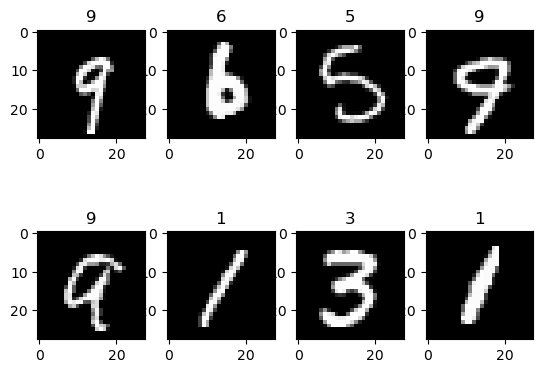

In [55]:
from mindspore import Model          # 定义深度学习模型
from matplotlib import pyplot as plt # 导入绘图库
import numpy as np                   # 用于数值计算的扩展库

# 将模型参数存入parameter的字典中，采用load_checkpoint接口加载模型参数
param_dict = ms.load_checkpoint("./save_direct.ckpt")

# 将参数加载到网络中
ms.load_param_into_net(net, param_dict)

#将net, loss, optimizer打包成一个Model
model = Model(net, loss, optimizer)

#迭代获取测试集图像和标签
data_test = test_dataset.create_dict_iterator()
data = next(data_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# 使用函数model.predict预测image对应分类
output = model.predict(ms.Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)

#可视化预测结果
plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title(pred[i-1])
plt.show()